In [6]:
import pandas as pd
import numpy as np

from datetime import date

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

Загружаем датасет и аггрегируем данные по часу
Проводим необходимые преобразования для использования  модели Prophet

In [7]:
df = pd.read_csv('nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.resample('H').sum()
df['time'] = df.index
df['y'] = df['value']
df['ds'] = df['time']
df

,value,time,y,ds
timestamp,,,,
2014-07-01 00:00:00,18971,2014-07-01 00:00:00,18971,2014-07-01 00:00:00
2014-07-01 01:00:00,10866,2014-07-01 01:00:00,10866,2014-07-01 01:00:00
2014-07-01 02:00:00,6693,2014-07-01 02:00:00,6693,2014-07-01 02:00:00
2014-07-01 03:00:00,4433,2014-07-01 03:00:00,4433,2014-07-01 03:00:00
2014-07-01 04:00:00,4379,2014-07-01 04:00:00,4379,2014-07-01 04:00:00
...,...,...,...,...
2015-01-31 19:00:00,56577,2015-01-31 19:00:00,56577,2015-01-31 19:00:00
2015-01-31 20:00:00,48276,2015-01-31 20:00:00,48276,2015-01-31 20:00:00
2015-01-31 21:00:00,48389,2015-01-31 21:00:00,48389,2015-01-31 21:00:00


Эта строка немного лишняя.
Имеется ввиду, что у нас будет датасет без 24 часов которые мы должны спрогнозировать

In [8]:
df1 = df[:-24]

Тренируем модель

In [9]:
model = Prophet()
model.fit(df1)
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -152.152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9216.16    0.00282019        82.996           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       9217.97   0.000155308       109.686    1.76e-06       0.001      251  LS failed, Hessian reset 
     199       9218.17   0.000116129       51.8092           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       9218.23   0.000160811       112.579   1.508e-06       0.001      384  LS failed, Hessian reset 
     278       9218.24   6.76033e-08       89.4906      0.1468      0.1468      432   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Визуализируем компоненты прогноза

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



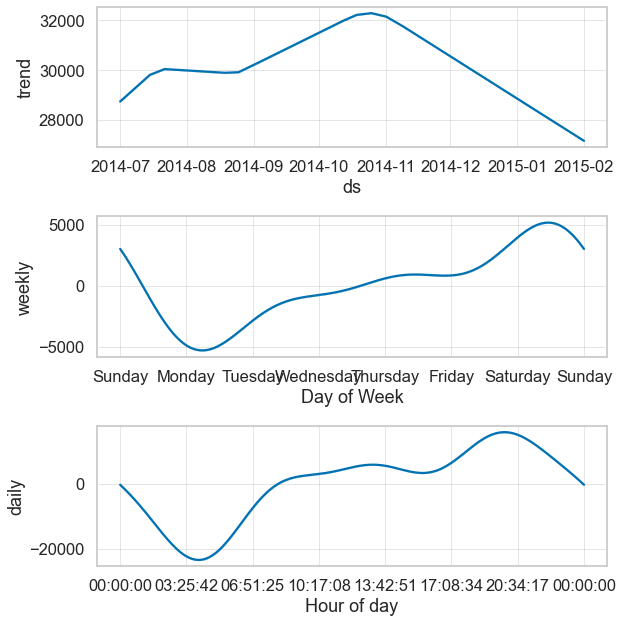

In [11]:
fig = model.plot_components(forecast)

Визуализируем результаты прогноза на графике вместе с оригинальными данными

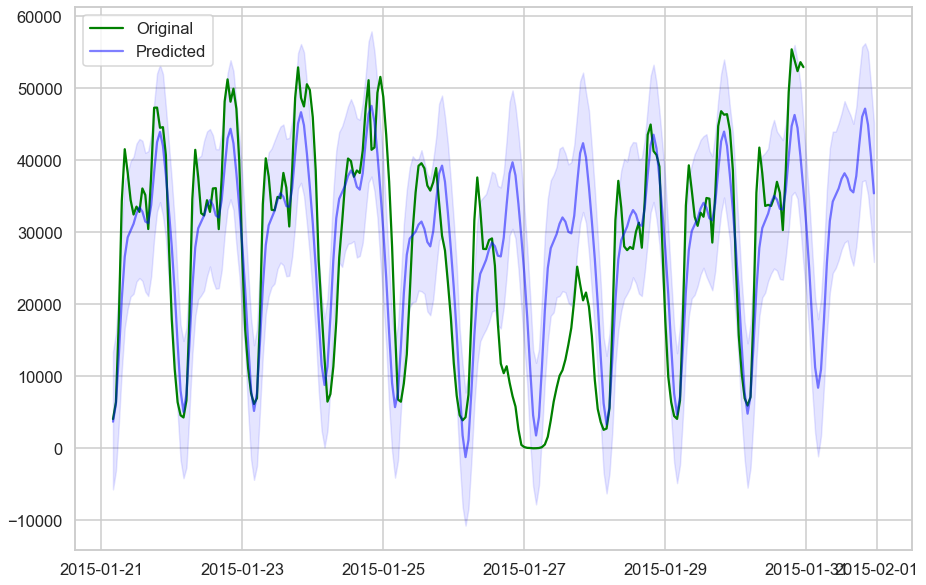

In [12]:
fig, ax = plt.subplots()
ax.plot(df1['ds'][4900:], df1['y'][4900:], label = 'Original', color='green')
ax.plot(forecast['ds'][4900:],forecast['yhat'][4900:], label = 'Predicted', color='blue', alpha=0.5)
ax.fill_between(forecast['ds'][4900:],forecast['yhat_lower'][4900:],forecast['yhat_upper'][4900:],
               color = 'blue',
               alpha=0.1)
ax.legend()
plt.show()

Забираем из датасета прогноза нужные нам колонки ds и yhat именно тех рядов которые мы прогнозируем. 
На следующие 24 часа

In [13]:
df_chek = forecast[['ds', 'yhat']][-24:]

Задаём величину для доверительного интервала
Сделал так, что бы доверительный интервал не мог быть в зоне отрицательных значений, что было бы нелогично в данной ситуации. Хотя нулевые значение возможны

In [14]:
if df_chek['yhat'].min() >= 15000:
    lower = 15000
else:
    lower = df_chek['yhat'].min() // 10 * 10

И для верхнего

In [16]:
upper = 15000

Добавляем колонки с готовыми значениями интервалов для прогноза

In [17]:
df_chek['yhat_lower'] = df_chek['yhat'].apply(lambda x: x - lower)
df_chek['yhat_upper'] = df_chek['yhat'].apply(lambda x: x + upper)
df_chek

,ds,yhat,yhat_lower,yhat_upper
5136,2015-01-31 00:00:00,30892.079884,22472.079884,45892.079884
5137,2015-01-31 01:00:00,24810.847528,16390.847528,39810.847528
5138,2015-01-31 02:00:00,17661.595567,9241.595567,32661.595567
5139,2015-01-31 03:00:00,11241.241960,2821.241960,26241.241960
5140,2015-01-31 04:00:00,8422.064897,2.064897,23422.064897
5141,2015-01-31 05:00:00,10959.316665,2539.316665,25959.316665
5142,2015-01-31 06:00:00,17833.405217,9413.405217,32833.405217
5143,2015-01-31 07:00:00,25767.410013,17347.410013,40767.410013
5144,2015-01-31 08:00:00,31572.705545,23152.705545,46572.705545
5145,2015-01-31 09:00:00,34270.523911,25850.523911,49270.523911


Загружаем новый дата сет через 24 часа. 
Проводим теже преобразования что и раньше. 
Сейчас нам нужна колонка со значениями на те 24 часа, которые мы прогнозировали

In [50]:
df = pd.read_csv('nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.resample('H').sum()
df['time'] = df.index
df['y'] = df['value']
df['ds'] = df['time']

Соеденяем наш подготовленый датасет с прогнозом и новый датасет с новыми значениями

In [51]:
df_chek = pd.merge_ordered(df_chek, df[['ds', 'y']][-24:])

Визуализируем, что бы посмотреть на сколько наш прогноз соответствовал действительности

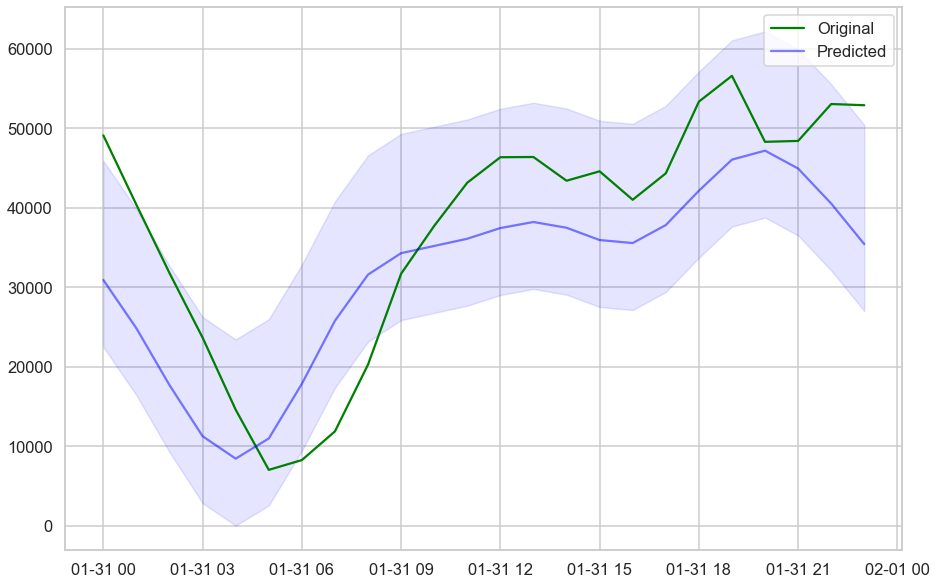

In [52]:
fig, ax = plt.subplots()
ax.plot(df_chek['ds'], df_chek['y'], label = 'Original', color='green')
ax.plot(df_chek['ds'],df_chek['yhat'], label = 'Predicted', color='blue', alpha=0.5)
ax.fill_between(df_chek['ds'],df_chek['yhat_lower'],df_chek['yhat_upper'],
               color = 'blue',
               alpha=0.1)
ax.legend()
plt.show()

Находим точки, где реальные значения вышли за зону доверительного интервала

In [53]:
df_chek['upper'] = df_chek['yhat_upper'] - df_chek['y']
df_chek['lower'] = df_chek['y'] - df_chek['yhat_lower']
df_chek

,ds,yhat,yhat_lower,yhat_upper,y,upper,lower
0,2015-01-31 00:00:00,30892.079884,22472.079884,45892.079884,49082,-3189.920116,26609.920116
1,2015-01-31 01:00:00,24810.847528,16390.847528,39810.847528,40342,-531.152472,23951.152472
2,2015-01-31 02:00:00,17661.595567,9241.595567,32661.595567,31755,906.595567,22513.404433
3,2015-01-31 03:00:00,11241.241960,2821.241960,26241.241960,23641,2600.241960,20819.758040
4,2015-01-31 04:00:00,8422.064897,2.064897,23422.064897,14573,8849.064897,14570.935103
5,2015-01-31 05:00:00,10959.316665,2539.316665,25959.316665,7012,18947.316665,4472.683335
6,2015-01-31 06:00:00,17833.405217,9413.405217,32833.405217,8245,24588.405217,-1168.405217
7,2015-01-31 07:00:00,25767.410013,17347.410013,40767.410013,11852,28915.410013,-5495.410013
8,2015-01-31 08:00:00,31572.705545,23152.705545,46572.705545,20262,26310.705545,-2890.705545
9,2015-01-31 09:00:00,34270.523911,25850.523911,49270.523911,31686,17584.523911,5835.476089


Отлавливаем точки и выводим в отдельный датафрейм, состоящий из значений вышедших за ожидаемую зону разброса

In [54]:
u = df_chek.loc[df_chek['upper'] < 0][['ds', 'y']]
l = df_chek.loc[df_chek['lower'] < 0][['ds', 'y']]
pd.merge_ordered(u, l)

,ds,y
0,2015-01-31 00:00:00,49082
1,2015-01-31 01:00:00,40342
2,2015-01-31 06:00:00,8245
3,2015-01-31 07:00:00,11852
4,2015-01-31 08:00:00,20262
5,2015-01-31 23:00:00,52879


Визуализируем график с точками выбросов за доверительный интервал

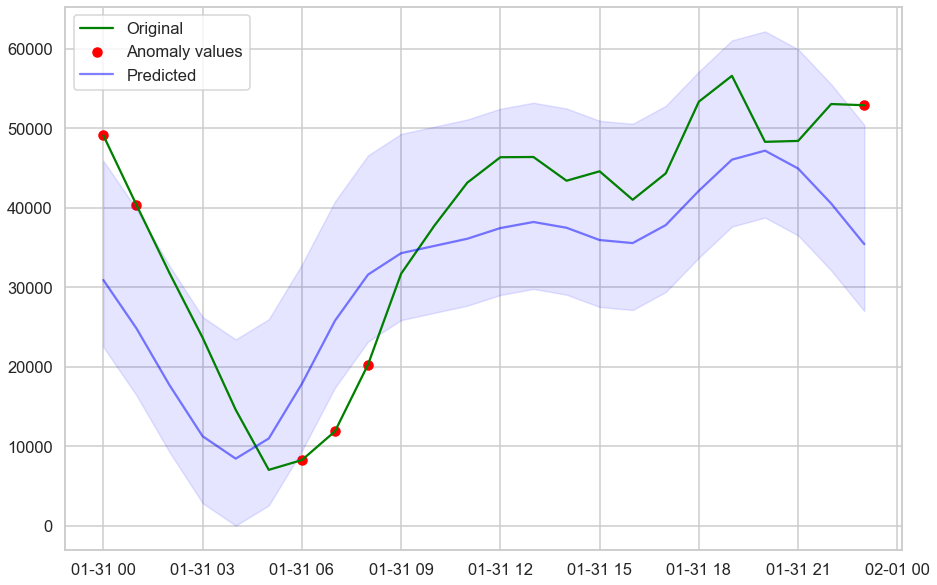

In [55]:
fig, ax = plt.subplots()
ax.plot(df_chek['ds'], df_chek['y'], label = 'Original', color='green')
ax.scatter(pd.merge_ordered(u, l)['ds'], pd.merge_ordered(u, l)['y'], label = 'Anomaly values', color='red')
ax.plot(df_chek['ds'],df_chek['yhat'], label = 'Predicted', color='blue', alpha=0.5)
ax.fill_between(df_chek['ds'],df_chek['yhat_lower'],df_chek['yhat_upper'],
               color = 'blue',
               alpha=0.1)
ax.legend()
plt.show()

Снова тренируем модель и повторяем все процедуры для того чтобы зафиксировать следующие ожидаемые значения

In [56]:
model_new = Prophet()
model_new.fit(df)
future_new = model_new.make_future_dataframe(periods=24, freq='H')
forecast_new = model_new.predict(future_new)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -152.044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9249.41    0.00203774       153.415           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       9250.28   0.000176265       142.373   1.054e-06       0.001      211  LS failed, Hessian reset 
     191       9251.16   0.000378679       245.542   3.389e-06       0.001      326  LS failed, Hessian reset 
     199       9251.27    0.00141306       186.514           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       9251.47   0.000172684       133.432   1.759e-06       0.001      437  LS failed, Hessian reset 
     284       9251.53   1.55757e-07       56.3978     0.06661           1      499   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



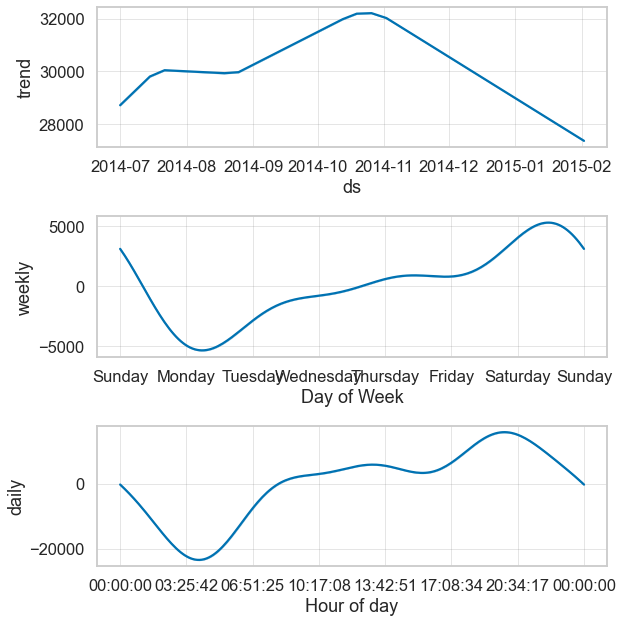

In [57]:
fig = model_new.plot_components(forecast_new)

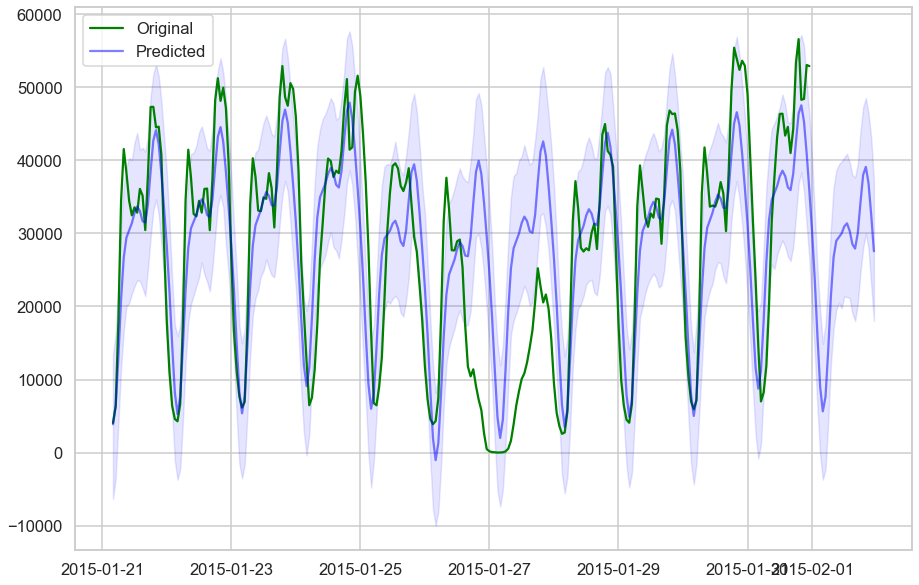

In [58]:
fig, ax = plt.subplots()
ax.plot(df['ds'][4900:], df['y'][4900:], label = 'Original', color='green')
ax.plot(forecast_new['ds'][4900:],forecast_new['yhat'][4900:], label = 'Predicted', color='blue', alpha=0.5)
ax.fill_between(forecast_new['ds'][4900:],forecast_new['yhat_lower'][4900:],forecast_new['yhat_upper'][4900:],
               color = 'blue',
               alpha=0.1)
ax.legend()
plt.show()

Создаём и сохраняем датафрейм с прогнозом на следующие 24 часа.
Потом мы сможем его снова загрузить и провести все необходимые процедуры для обнаружения выбросов
Модель Prophet очень хорошо предсказывает поведение данных и учитывает недельную сезонность, которую явно видно при визуальзации данных

In [59]:
today = date.today()
name = f'Forecast from {today}'
df_save = forecast_new[['ds', 'yhat']][-24:]
df_save.to_csv(f'{name}.csv', encoding='utf-8')